# HB KGL
_______

## Objective

This exercise is the resolution of the Kaggle problem [Give Me Some Credit](https://www.kaggle.com/c/GiveMeSomeCredit/).

To reformulate it, we will consider `cs-training.csv` dataset, remove the 1st column (index) and try to find the best algorithm to predict Column 2 `SeriousDlqin2yrs`, based on the other ones.

As `SeriousDlqin2yrs` has 2 values only, this is a classification problem. With the [scikit-learn](http://scikit-learn.org/) Python library we will apply different algorithms, and try to find the best one. As it becomes an optimization problem, we have to choose a measure to optimize: we'll use the **AUC (Area Under the Curve)**, applied on a subset and its complimentary of the original training dataset.
I think the challenge chose this metric because the **AUC** of the **ROC curve** is a perfect indicator for *binary classification*.
I chose of **AUC**, to fit with the the challenge, and also because it's quite easy to analyse the results by simply reading the curve. Also the implementation in *scikit-learn* is great.
About the alternative, they could have chosen `f1` for example (good for binary classification too).

To determine the subsets and their complementaries, we'll use **Cross-Validation**.

Finally to optimize our model (and affine the hyper parameters), we'll use a **Grid Search** method.

We're working on a pretty standard Data Science Stack: `Jupyter` + `Python3` + `Pandas` + `Matplotlib` + `sklearn`
Everything is virtualized behind *Docker* 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load dataset

In [2]:
data = pd.read_csv('data/cs-training.csv').drop('Unnamed: 0', axis = 1)

## First try
We have a classification model, we try to predict the value (1 or 0) of `SeriousDlqin2yrs`.

In [3]:
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data.SeriousDlqin2yrs

In [4]:
X.describe()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


To apply a model, we first need to fill the blanks in `MonthlyIncome` and `NumberOfDependents`. We will fill with medians

In [5]:
X.loc[X.MonthlyIncome.isnull(), 'MonthlyIncome'] = X.MonthlyIncome.median()
X.loc[X.NumberOfDependents.isnull(), 'NumberOfDependents'] = X.NumberOfDependents.median()

In [6]:
X.describe()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,6.048438,52.295207,0.421033,353.005076,6.418455e+03,8.452760,0.265973,1.018240,0.240387,0.737413
std,249.755371,14.771866,4.192781,2037.818523,1.289040e+04,5.145951,4.169304,1.129771,4.155179,1.107021
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029867,41.000000,0.000000,0.175074,3.903000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


As a first approach, we try to use a logistic regression. As we want to evaluate this model, we choose to cross validate the model (https://en.wikipedia.org/wiki/Cross-validation_(statistics))

In [7]:
from sklearn.cross_validation import StratifiedKFold

/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
# CVNFOLDS = 7
# cv = StratifiedKFold(y, n_folds=CVNFOLDS)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

In [10]:
def eval_model(mod, X, y, CVNFOLDS=7):
    cv = StratifiedKFold(y, n_folds=CVNFOLDS)
    mem = []
    for i, (training, test) in enumerate(cv):
        fit = mod.fit(X.iloc[training], y.iloc[training])
        prob = fit.predict_proba(X.iloc[test])
        fpr, tpr, _ = roc_curve(y.iloc[test], prob[:, 1])
        a = auc(fpr, tpr)
        mem.append(a)
        print('ROC: %f' % a)
        plt.plot(fpr, tpr)
    plt.xlabel('False Positive Ratio')
    plt.ylabel('True Positive Ratio')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    print("Mean: %f" % np.mean(mem))

ROC: 0.692877
ROC: 0.690494
ROC: 0.696284
ROC: 0.687494
ROC: 0.703366
ROC: 0.705614
ROC: 0.698438
Mean: 0.696367


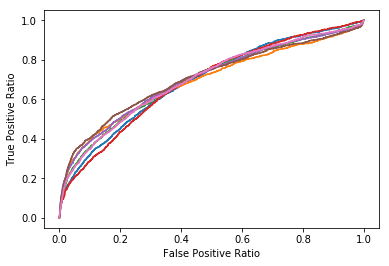

In [11]:
eval_model(LogisticRegression(), X, y)

Wich brings us at the position 830-ish... Could be better!
![leaderboard](https://www.dropbox.com/s/o5vleyi2rxywmle/Screenshot%202017-03-27%2011.16.11.png?dl=1)

**Let's try to clean a bit more our dataset**

## Analyse the set
**First we reload a fresh set**

In [12]:
data = pd.read_csv('data/cs-training.csv').drop('Unnamed: 0', axis = 1)

### SeriousDlqin2yrs

In [13]:
from collections import Counter

In [14]:
Counter(data.SeriousDlqin2yrs)

Counter({0: 139974, 1: 10026})

### Age

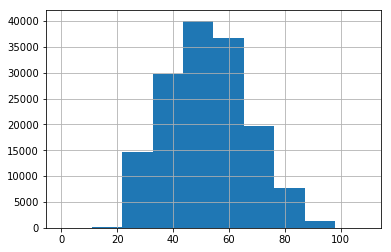

In [15]:
data.age.hist()

In [16]:
Counter(data[data.age<30].age)

Counter({0: 1,
         21: 183,
         22: 434,
         23: 641,
         24: 816,
         25: 953,
         26: 1193,
         27: 1338,
         28: 1560,
         29: 1702})

Only one `0`, this is probably a mistake, replacing by the median

In [17]:
data.loc[data.age < 21, 'age'] = data.age.median()

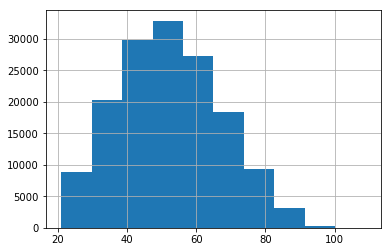

In [18]:
data.age.hist()

In [19]:
Counter(data[data.age>100].age)

Counter({101.0: 3, 102.0: 3, 103.0: 3, 105.0: 1, 107.0: 1, 109.0: 2})

### NumberOfTime3059DaysPastDueNotWorse

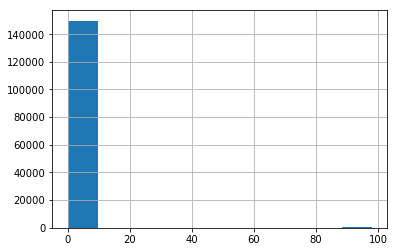

In [20]:
data["NumberOfTime30-59DaysPastDueNotWorse"].hist()

In [21]:
Counter(data["NumberOfTime30-59DaysPastDueNotWorse"])

Counter({0: 126018,
         1: 16033,
         2: 4598,
         3: 1754,
         4: 747,
         5: 342,
         6: 140,
         7: 54,
         8: 25,
         9: 12,
         10: 4,
         11: 1,
         12: 2,
         13: 1,
         96: 5,
         98: 264})

We assume 96 & 98 are mistakes

In [22]:
data.loc[
    data["NumberOfTime30-59DaysPastDueNotWorse"] > 20,
    'NumberOfTime30-59DaysPastDueNotWorse',
] = data["NumberOfTime30-59DaysPastDueNotWorse"].median()

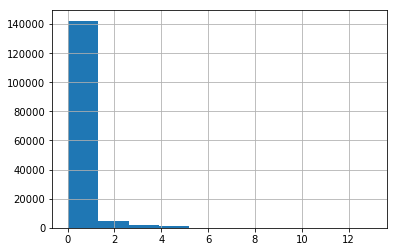

In [23]:
data["NumberOfTime30-59DaysPastDueNotWorse"].hist()

### NumberOfTimes90DaysLate

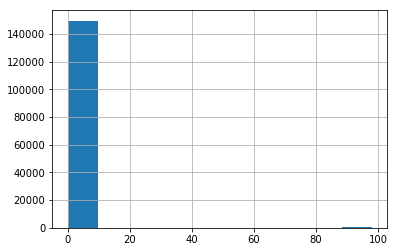

In [24]:
data.NumberOfTimes90DaysLate.hist()

In [25]:
Counter(data.NumberOfTimes90DaysLate)

Counter({0: 141662,
         1: 5243,
         2: 1555,
         3: 667,
         4: 291,
         5: 131,
         6: 80,
         7: 38,
         8: 21,
         9: 19,
         10: 8,
         11: 5,
         12: 2,
         13: 4,
         14: 2,
         15: 2,
         17: 1,
         96: 5,
         98: 264})

Same mistake ?

In [26]:
data.loc[
    data.NumberOfTimes90DaysLate > 20,
    'NumberOfTimes90DaysLate',
] = data.NumberOfTimes90DaysLate.median()

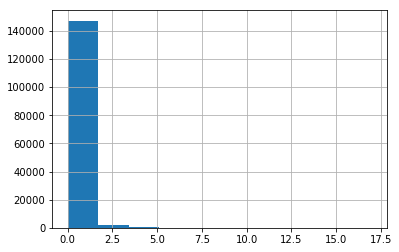

In [27]:
data.NumberOfTimes90DaysLate.hist()

### NumberRealEstateLoansOrLines

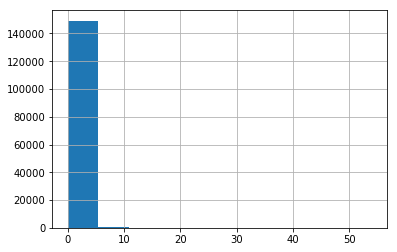

In [28]:
data.NumberRealEstateLoansOrLines.hist()

In [29]:
Counter(data.NumberRealEstateLoansOrLines)

Counter({0: 56188,
         1: 52338,
         2: 31522,
         3: 6300,
         4: 2170,
         5: 689,
         6: 320,
         7: 171,
         8: 93,
         9: 78,
         10: 37,
         11: 23,
         12: 18,
         13: 15,
         14: 7,
         15: 7,
         16: 4,
         17: 4,
         18: 2,
         19: 2,
         20: 2,
         21: 1,
         23: 2,
         25: 3,
         26: 1,
         29: 1,
         32: 1,
         54: 1})

It seems acceptable

### NumberOfDependents

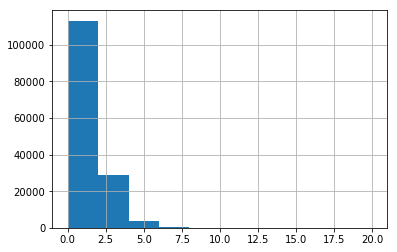

In [30]:
data.NumberOfDependents.hist()

In [31]:
# Counter(data.NumberOfDependents)

As done in the first section, let's remove the nulls

In [32]:
data.loc[
    data.NumberOfDependents.isnull(),
    'NumberOfDependents',
] = data.NumberOfDependents.median()

In [33]:
Counter(data.NumberOfDependents)
# data.NumberOfDependents[data.NumberOfDependents.isnull()]

Counter({0.0: 90826,
         1.0: 26316,
         2.0: 19522,
         3.0: 9483,
         4.0: 2862,
         5.0: 746,
         6.0: 158,
         7.0: 51,
         8.0: 24,
         9.0: 5,
         10.0: 5,
         13.0: 1,
         20.0: 1})

More than 10 dependents is too rare

In [34]:
data.loc[
    data.NumberOfDependents > 10,
    'NumberOfDependents',
] = 10

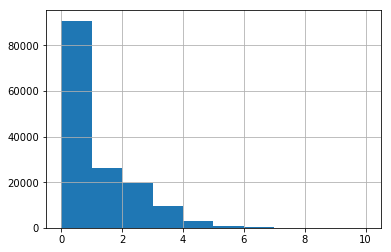

In [35]:
data.NumberOfDependents.hist()

### RevolvingUtilizationOfUnsecuredLines

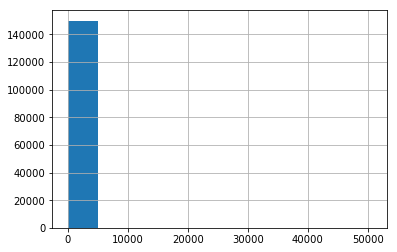

In [36]:
data.RevolvingUtilizationOfUnsecuredLines.hist()

In [37]:
data.loc[
    data.RevolvingUtilizationOfUnsecuredLines > 5,
    'RevolvingUtilizationOfUnsecuredLines',
] = data.RevolvingUtilizationOfUnsecuredLines.median()

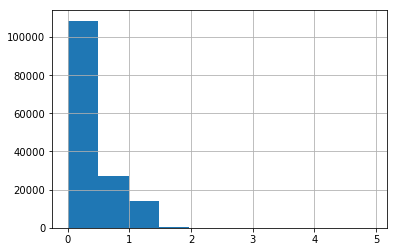

In [38]:
data.RevolvingUtilizationOfUnsecuredLines.hist()

It seems acceptable

### DebtRatio

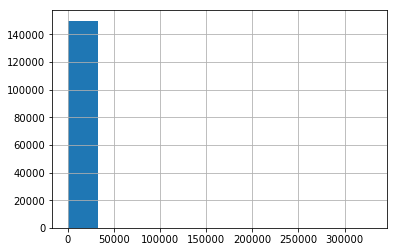

In [39]:
data.DebtRatio.hist()

In [40]:
# Counter(data.DebtRatio)

In [41]:
data.loc[
    data.DebtRatio > 5,
    'DebtRatio',
] = data.DebtRatio.median()

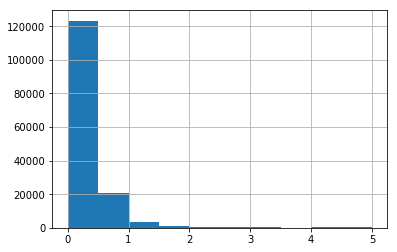

In [42]:
data.DebtRatio.hist()

In [43]:
data.DebtRatio.describe()

count    150000.000000
mean          0.371200
std           0.394357
min           0.000000
25%           0.175074
50%           0.366506
75%           0.414913
max           5.000000
Name: DebtRatio, dtype: float64

### MonthlyIncome

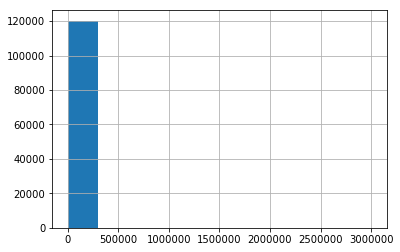

In [44]:
data.MonthlyIncome.hist()

In [45]:
data.MonthlyIncome.describe()

count    1.202690e+05
mean     6.670221e+03
std      1.438467e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

In [46]:
data.loc[data.MonthlyIncome.isnull(), 'MonthlyIncome'] = data.MonthlyIncome.median()

In [47]:
data.MonthlyIncome.describe()

count    1.500000e+05
mean     6.418455e+03
std      1.289040e+04
min      0.000000e+00
25%      3.903000e+03
50%      5.400000e+03
75%      7.400000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

### NumberOfOpenCreditLinesAndLoans

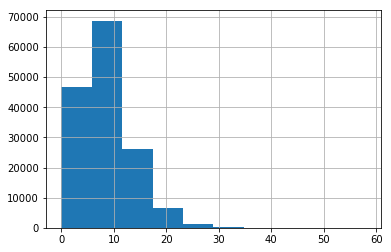

In [48]:
data.NumberOfOpenCreditLinesAndLoans.hist()

In [49]:
data.NumberOfOpenCreditLinesAndLoans.describe()

count    150000.000000
mean          8.452760
std           5.145951
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

It seems acceptable

### NumberOfTime60-89DaysPastDueNotWorse

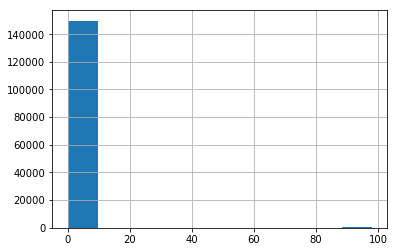

In [50]:
data["NumberOfTime60-89DaysPastDueNotWorse"].hist()

In [51]:
data["NumberOfTime60-89DaysPastDueNotWorse"].describe()

count    150000.000000
mean          0.240387
std           4.155179
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: float64

It seems acceptable

### Check

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2f4bfdceb8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2f4bab3518>]], dtype=object)

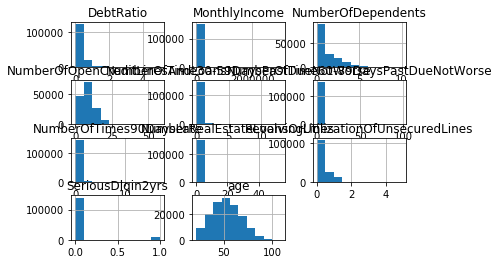

In [52]:
data.hist()

## Predictions
### Logistic regression

In [53]:
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data.SeriousDlqin2yrs

ROC: 0.778841
ROC: 0.781425
ROC: 0.774707
ROC: 0.775001
ROC: 0.785015
ROC: 0.780113
ROC: 0.788260
Mean: 0.780480


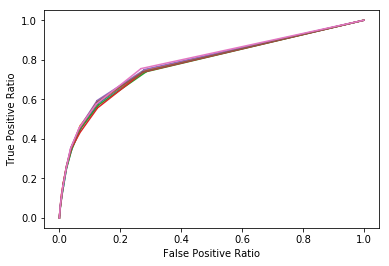

In [54]:
from sklearn.ensemble import RandomForestClassifier
eval_model(RandomForestClassifier(), X, y)

ROC: 0.834614
ROC: 0.807672
ROC: 0.804414
ROC: 0.839437
ROC: 0.846212
ROC: 0.826533
ROC: 0.852132
Mean: 0.830145


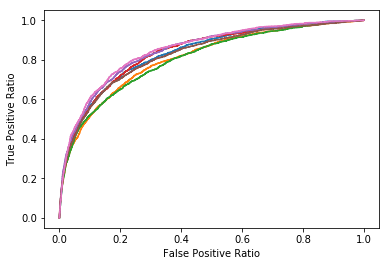

In [55]:
eval_model(LogisticRegression(), X, y)

**Position 575-ish**

ROC: 0.855108
ROC: 0.857138
ROC: 0.858318
ROC: 0.857415
ROC: 0.864138
ROC: 0.853770
ROC: 0.867405
Mean: 0.859042


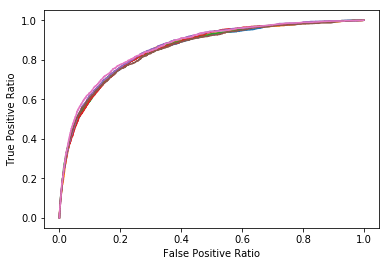

In [56]:
from sklearn.ensemble import AdaBoostClassifier
eval_model(AdaBoostClassifier(), X, y)

**Position 545-ish**

ROC: 0.859633
ROC: 0.862674
ROC: 0.862557
ROC: 0.862817
ROC: 0.867791
ROC: 0.859776
ROC: 0.873475
Mean: 0.864103


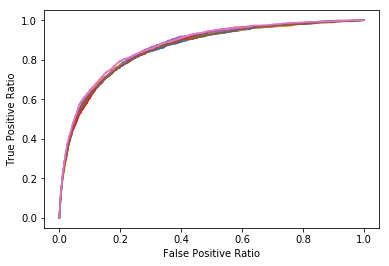

In [57]:
from sklearn.ensemble import GradientBoostingClassifier
eval_model(GradientBoostingClassifier(), X, y)

**Position 410-ish**

ROC: 0.784015
ROC: 0.723517
ROC: 0.832748
ROC: 0.756130
ROC: 0.759331
ROC: 0.629100
ROC: 0.685176
Mean: 0.738574


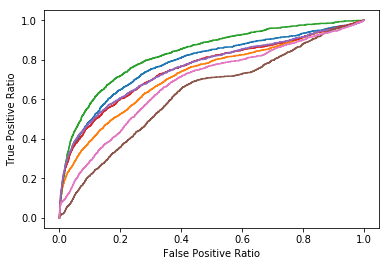

In [58]:
from sklearn.neural_network import MLPClassifier
eval_model(MLPClassifier(), X, y)

We could have guessed that NN classifier wouldn't have worked, as NN needs hyper parameters to be selected carefully, and that require a lot of time. Let's skip that model for now.

## Optimization of the `GradientBoostingClassifier` 

We'll use the **Grid Search** technique to determine the best hyper parameters for that model. We will try to optimize 3 parameters for this classifier:

- n_estimators
- max_depth
- min_samples_split

In [59]:
from sklearn.model_selection import GridSearchCV

### n_estimators

In [60]:
# parameters = {'n_estimators': range(50,301,50)}
# parameters = {'n_estimators': range(300,701,100)}
# parameters = {'n_estimators': range(250,350,25)}
# parameters = {'n_estimators': range(260,290,5)}

# gs = GridSearchCV(GradientBoostingClassifier(), parameters, scoring='roc_auc')
# gs.fit(X, y)
# print(gs.best_params_, gs.best_score_)
# """0.864308632568"""

### max_depth

In [61]:
# parameters = {'max_depth': range(2,5,1)}
# gs = GridSearchCV(GradientBoostingClassifier(
#     n_estimators=270,
# ), parameters, scoring='roc_auc')
# gs.fit(X, y)
# print(gs.best_params_, gs.best_score_)
# """{'max_depth': 3} 0.864232407631"""

### min_samples_split

In [62]:
# parameters = {'min_samples_split': range(1,4,1)}
# gs = GridSearchCV(GradientBoostingClassifier(
#     n_estimators=270,
#     max_depth=3,
# ), parameters, scoring='roc_auc')
# gs.fit(X, y)
# print(gs.best_params_, gs.best_score_)
# """{'min_samples_split': 2} 0.864284540721"""

### Evaluation

ROC: 0.861150
ROC: 0.863785
ROC: 0.863296
ROC: 0.863805
ROC: 0.868971
ROC: 0.860010
ROC: 0.874524
Mean: 0.865077


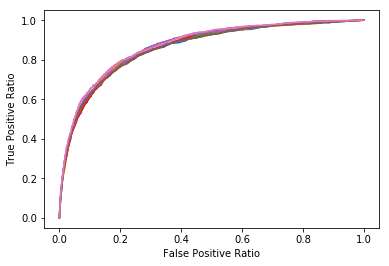

In [63]:
eval_model(GradientBoostingClassifier(
    n_estimators=270,
    max_depth=3,
    min_samples_split=2,
), X, y)

By changing the parameters, we can reach **position 240-ish**

## To go further

We reached quite easily the position 240-ish, but our data has been cleaned quickly. A more complete model would replace the `NA` using a *predictive model* (based on the other columns). I think it might be useful, especially for the incomes.

We should also be able to adjust the coefficient of the models with more precisions. I think we can continue with Gradient Boosting Classifier, as it offers the best results.

